# Convolutional Net for Sentiment Classification

This Conv Net performs sentiment analysis on the IMDB review dataset.

In [1]:
import os
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Layer, Embedding, Conv1D, SpatialDropout1D, GlobalMaxPool1D
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras_contrib.layers.advanced_activations import SineReLU

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import sklearn.metrics
from sklearn.metrics import roc_auc_score

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameters

In [2]:
output_dir = 'model_output/conv'

epochs = 10
batch_size = 64
patience = 10
val_split = .3

n_dim = 192
n_unique_words = 20000
max_review_length = 200
pad_type = trunc_type = 'pre'

n_conv = 128
k_conv = 3

n_dense = 256
dropout = 0.5

#### Load Data

In [3]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Preprocess Data

In [4]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design Conv Net Architecture

In [6]:
e_cnn, e_dense= 0.055, 0.005

model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Conv1D(n_conv, k_conv))
model.add(SineReLU(e_cnn))
# model.add(Activation('relu'))
model.add(GlobalMaxPool1D())

model.add(Dense(n_dense))
model.add(SineReLU(e_dense))
# model.add(Activation('relu'))

model.add(Dense(n_dense))
model.add(SineReLU(e_dense))
# model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 192)          3840000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 128)          73856     
_________________________________________________________________
sine_re_lu_1 (SineReLU)      (None, 198, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
sine_re_lu_2 (SineReLU)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
__________

#### Configure the Model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelCheckpoint = ModelCheckpoint(monitor='val_acc', filepath=output_dir + '/best-cnn-imdb-model.hdf5', save_best_only=True, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', mode='max', patience=patience)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### TensorBoard

In [10]:
tensorboard = TensorBoard("../logs/imdb-cnn-relus")

### Train the Model

In [11]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=val_split, callbacks=[modelCheckpoint, earlyStopping])#, tensorboard])

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 45s 3ms/step - loss: 0.4236 - acc: 0.7914 - val_loss: 0.2851 - val_acc: 0.8803
Epoch 2/10
17500/17500 [==============================] - 46s 3ms/step - loss: 0.1374 - acc: 0.9495 - val_loss: 0.2992 - val_acc: 0.8787
Epoch 3/10
17500/17500 [==============================] - 45s 3ms/step - loss: 0.0215 - acc: 0.9940 - val_loss: 0.4328 - val_acc: 0.8729
Epoch 4/10
17500/17500 [==============================] - 45s 3ms/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.5025 - val_acc: 0.8831
Epoch 5/10
17500/17500 [==============================] - 47s 3ms/step - loss: 0.0061 - acc: 0.9980 - val_loss: 0.5724 - val_acc: 0.8713
Epoch 6/10
17500/17500 [==============================] - 45s 3ms/step - loss: 0.0303 - acc: 0.9885 - val_loss: 0.6549 - val_acc: 0.8463
Epoch 7/10
17500/17500 [==============================] - 45s 3ms/step - loss: 0.0250 - acc: 0.9910 - val_loss: 0.4671 - val_acc:

#### Evaluate

In [12]:
model = keras.models.load_model(output_dir+'/best-cnn-imdb-model.hdf5')

In [13]:
y_hat = model.predict_proba(X_valid)
final_loss, final_acc = model.evaluate(X_valid, y_valid, verbose = 1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

25000/25000 [==============================] - 13s 524us/step
Final loss: 0.5385, final accuracy: 0.8751


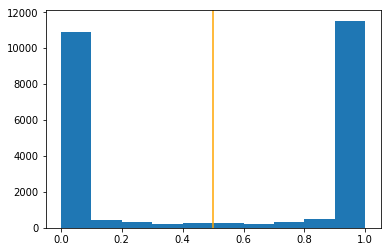

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
pct_auc = roc_auc_score(y_valid, y_hat) * 100

In [16]:
print('{:0.2f}'.format(pct_auc))
print(np.std(history.history['loss']))

94.87
0.12450807406114713


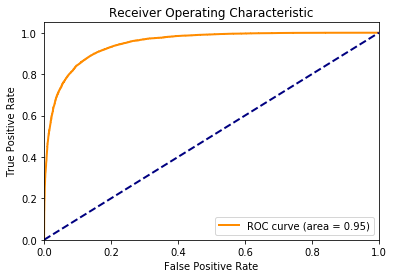

In [17]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_valid, y_hat)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

In [18]:
#SineReLU V2

#Final loss: 0.2871, final accuracy: 0.8799 -> SineReLU (0.0025, 0.0055); STD loss => 0.1282695799687545; AUC => 95.02
#Final loss: 0.6411, final accuracy: 0.8774 -> SineReLU (0.055, 0.005); STD loss => 0.1282695799687545; AUC => 94.95
#Final loss: 0.3048, final accuracy: 0.8754 -> SineReLU (0.055, 0.005); STD loss => 0.12582034191497002; AUC => 94.92
#Final loss: 0.5410, final accuracy: 0.8735 -> SineReLU (0.055, 0.005); STD loss => 0.12481875562430332; AUC => 94.92
#Final loss: 0.5385, final accuracy: 0.8751 -> SineReLU (0.055, 0.005); STD loss => 0.12450807406114713; AUC => 94.87
#Final loss: 0.4456, final accuracy: 0.8764 -> SineReLU (0.055, 0.005); STD loss => 0.12449238880646624; AUC => 94.82
#Final loss: 0.6634, final accuracy: 0.8681 -> SineReLU (0.0025, 0.0055); STD loss => 0.12587642315152103; AUC => 94.41

#SineReLU V1
#Final loss: 0.6132, final accuracy: 0.8790 -> SineReLU (0.005, 0.003); STD loss => 0.12761551802489726; AUC => 95.16
#Final loss: 0.3057, final accuracy: 0.8772 -> SineReLU (0.0025, 0.0055); STD loss => 0.12435647601321513; AUC => 94.94
#Final loss: 0.5346, final accuracy: 0.8772 -> SineReLU (0.0055, 0.0083); STD loss => 0.12336675416111663; AUC => 94.89
#Final loss: 0.5471, final accuracy: 0.8714 -> SineReLU (0.0025, 0.0055); STD loss => 0.12421548940177027; AUC => 94.88

#ReLU

# 1st and 3rd with overfitting during training.
#Final loss: 0.2918, final accuracy: 0.8756 -> ReLU; STD loss => 0.12667813809127826; AUC => 94.92
#Final loss: 0.6250, final accuracy: 0.8783 -> ReLU; STD loss => 0.13021323478326338; AUC => 95.01
#Final loss: 0.2878, final accuracy: 0.8772 -> ReLU; STD loss => 0.12688453456699963; AUC => 95.00
